In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

In [2]:
FILE_PATH = '/content/liver_cirrhosis.csv'
TARGET_COLUMN = 'Stage'

In [3]:
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [4]:
try:
    data = pd.read_csv(FILE_PATH)
    print(f"Data loaded successfully. Shape: {data.shape}")
except FileNotFoundError:
    print(f"Error: File not found at '{FILE_PATH}'. Please upload your dataset.")
    data = None

if data is not None:
    print("\nFirst 5 rows of the dataset:")
    print(data.head())
    print("\nDataset Information:")
    data.info()

Data loaded successfully. Shape: (25000, 19)

First 5 rows of the dataset:
   N_Days Status     Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0    2221      C  Placebo  18499   F       N            Y       N     N   
1    1230      C  Placebo  19724   M       Y            N       Y     N   
2    4184      C  Placebo  11839   F       N            N       N     N   
3    2090      D  Placebo  16467   F       N            N       N     N   
4    2105      D  Placebo  21699   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        0.5        149.0     4.04   227.0     598.0   52.70           57.0   
1        0.5        219.0     3.93    22.0     663.0   45.00           75.0   
2        0.5        320.0     3.54    51.0    1243.0  122.45           80.0   
3        0.7        255.0     3.74    23.0    1024.0   77.50           58.0   
4        1.9        486.0     3.54    74.0    1052.0  108.50          109.0   


In [5]:
if data is not None:
    # 1. Age Conversion (Days to Years)
    data['Age_Years'] = data['Age'] / 365.25
    data = data.drop('Age', axis=1)

    # 2. Handling Missing Data Artifacts
    # Identify placeholder values from inspection (may need adjustment based on full dataset)
    placeholders = [369.5105634, 124.7021277, 10.73173077]
    data = data.replace(placeholders, np.nan)

    # Check for remaining NaNs
    print("\nMissing values (after cleaning artifacts):")
    print(data.isnull().sum())
    # 3. Imputation (using Median for robustness against outliers)
    numerical_cols = ['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
                      'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Age_Years']

    imputer = SimpleImputer(strategy='median')
    data[numerical_cols] = imputer.fit_transform(data[numerical_cols])

    # Impute missing categorical values (e.g., 'Drug', 'Edema', 'Hepatomegaly') with the mode
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].fillna(data[col].mode()[0])

    print("\nMissing values (after imputation):")
    print(data.isnull().sum().sum())

    # Drop 'N_Days' and 'Status' as they relate to survival time/censoring, not the initial stage detection
    data = data.drop(['N_Days', 'Status'], axis=1)


Missing values (after cleaning artifacts):
N_Days              0
Status              0
Drug                0
Sex                 0
Ascites             0
Hepatomegaly        0
Spiders             0
Edema               0
Bilirubin           0
Cholesterol      8310
Albumin             0
Copper              0
Alk_Phos            0
SGOT                0
Tryglicerides    8461
Platelets           0
Prothrombin       150
Stage               0
Age_Years           0
dtype: int64

Missing values (after imputation):
0


In [6]:
if data is not None:
    # 4. Feature Transformation (Encoding)

    # Ordinal Encoding for 'Edema' (N < S < Y)
    edema_mapping = {'N': 0, 'S': 1, 'Y': 2}
    data['Edema_Encoded'] = data['Edema'].map(edema_mapping)
    data = data.drop('Edema', axis=1)

    # Binary/Nominal Encoding for other features
    binary_cols = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Drug']

    # Map 'M'/'F', 'N'/'Y', 'D'/'Placebo' to 0/1 for simplicity
    mapping = {'M': 0, 'F': 1, 'N': 0, 'Y': 1, 'Placebo': 0, 'D-penicillamine': 1}
    for col in binary_cols:
        if col in data.columns:
            data[col] = data[col].map(mapping)

    # Separate features (X) and target (y)
    X = data.drop(TARGET_COLUMN, axis=1)
    y = data[TARGET_COLUMN]

    print("\nFeatures after encoding:")
    print(X.head())

    # Scaling numerical features
    scaler = StandardScaler()
    X_scaled = X.copy()

    # Re-define numerical columns after dropping/adding
    numerical_features_final = [col for col in X.columns if col not in ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Drug', 'Edema_Encoded']]

    X_scaled[numerical_features_final] = scaler.fit_transform(X_scaled[numerical_features_final])
    X = X_scaled

    # Convert target to integer type (if not already)
    y = y.astype(int)

    # Check target distribution
    print(f"\nTarget Variable ('{TARGET_COLUMN}') Distribution:")
    print(y.value_counts().sort_index())



Features after encoding:
   Drug  Sex  Ascites  Hepatomegaly  Spiders  Bilirubin  Cholesterol  Albumin  \
0     0    1        0             1        0        0.5        149.0     4.04   
1     0    0        1             0        1        0.5        219.0     3.93   
2     0    1        0             0        0        0.5        320.0     3.54   
3     0    1        0             0        0        0.7        255.0     3.74   
4     0    1        0             1        0        1.9        486.0     3.54   

   Copper  Alk_Phos    SGOT  Tryglicerides  Platelets  Prothrombin  Age_Years  \
0   227.0     598.0   52.70           57.0      256.0          9.9  50.647502   
1    22.0     663.0   45.00           75.0      220.0         10.8  54.001369   
2    51.0    1243.0  122.45           80.0      225.0         10.0  32.413415   
3    23.0    1024.0   77.50           58.0      151.0         10.2  45.084189   
4    74.0    1052.0  108.50          109.0      151.0         11.5  59.408624   



In [7]:
if data is not None:
    # Split the data (80% train, 20% test)
    # Stratify ensures similar proportion of Stages in both sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    # Initialize and train the Random Forest Classifier
    # Using class_weight='balanced' is important due to potential class imbalance
    model = RandomForestClassifier(n_estimators=150,
                                   max_depth=15,
                                   min_samples_leaf=5,
                                   random_state=42,
                                   n_jobs=-1,
                                   class_weight='balanced')

    print("\nStarting model training...")
    model.fit(X_train, y_train)
    print("Model training complete.")



Training set shape: (20000, 16), Test set shape: (5000, 16)

Starting model training...
Model training complete.



Overall Test Accuracy: 0.9400

Classification Report (Stages 1, 2, 3):
              precision    recall  f1-score   support

     Stage 1       0.95      0.92      0.93      1653
     Stage 2       0.91      0.95      0.93      1688
     Stage 3       0.96      0.95      0.96      1659

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



/tmp/ipython-input-3762125527.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='plasma')


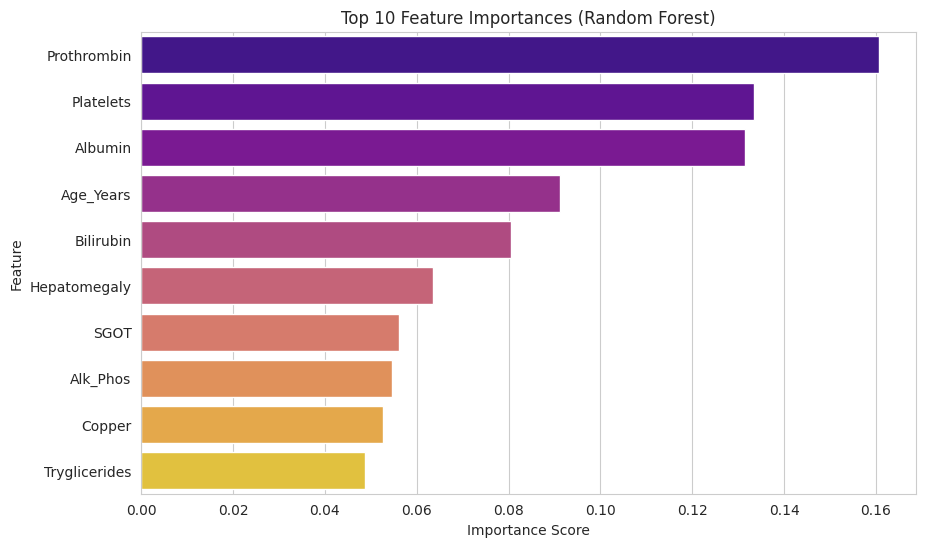


--- Model Summary ---
The model achieved an accuracy of 0.94 in detecting the liver cirrhosis stage.
The most important features influencing the stage detection (top 3) are likely:
['Prothrombin', 'Platelets', 'Albumin']


In [8]:
if data is not None:
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nOverall Test Accuracy: {accuracy:.4f}")

    # Generate a detailed classification report
    print("\nClassification Report (Stages 1, 2, 3):")
    print(classification_report(y_test, y_pred, target_names=['Stage 1', 'Stage 2', 'Stage 3'], zero_division=0))

    # Feature Importance Visualization
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    top_features = feature_importances.nlargest(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette='plasma')
    plt.title('Top 10 Feature Importances (Random Forest)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

    # Interpretation
    print("\n--- Model Summary ---")
    print(f"The model achieved an accuracy of {accuracy:.2f} in detecting the liver cirrhosis stage.")
    print("The most important features influencing the stage detection (top 3) are likely:")
    print(top_features.index[:3].tolist())
